In [1]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
import scipy
from collections import namedtuple
import numpy as np
import cupy as cp
import math
import json

%run utils.ipynb

In [2]:
config = Config()

In [3]:
%%time
IMAGE_SIZE = -1
IMAGES = []
IMAGES_BW = []
IMAGES_METADATA = []

with open(os.path.join(config.dataset_path, config.dataset_metadata_file_name)) as f:
    metadata = json.load(f)

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    if not image_fname.endswith('.png'):
        continue

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.width == IMAGE_SIZE or IMAGE_SIZE == -1
        IMAGE_SIZE = image.width
        assert image.mode == 'L'
        image_index = len(IMAGES)
        IMAGES.append(np.array(image).ravel())
        metadata_record = metadata[os.path.basename(image_fname)]
        metadata_record = np.rec.array([(image_fname, metadata_record.get('value', '?'))], dtype=[('file_name', 'object'), ('value', 'object')])
        IMAGES_METADATA.append(metadata_record)
        
    assert image.fp is None

assert len(IMAGES) == len(IMAGES_METADATA)
IMAGES = np.array(IMAGES)
IMAGES_BW = (IMAGES / 255).astype(np.uint8)
IMAGES_BW_ONES = IMAGES_BW @ np.ones(IMAGES_BW.shape[1]).T
assert np.array_equal(IMAGES_BW_ONES[:10], (IMAGES_BW[:10] == 1).sum(axis=-1))
IMAGES_METADATA = np.rec.array(np.concatenate(IMAGES_METADATA))
print(f'Loaded {len(IMAGES)} images')

  0%|          | 0/9202 [00:00<?, ?it/s]

Loaded 9201 images
CPU times: user 1.13 s, sys: 135 ms, total: 1.26 s
Wall time: 1.45 s


In [4]:
def draw_kernel_bar(p1, p2, p3, p4, size=32):
    image = Image.new('L', (size, size), 0)
    draw = ImageDraw.Draw(image)
    draw.polygon([tuple(p1), tuple(p2), tuple(p3), tuple(p4)], fill=255, outline=255, width=1)
    return image
    
def get_kernel_size(kernel):
    if len(kernel.shape) == 1: # Raveled array
        size = int(math.sqrt(kernel.shape[0]))
        assert size * size == kernel.shape[0]
        return size
        
    assert len(kernel.shape) == 2
    assert kernel.shape[0] == kernel.shape[1]
    assert kernel.dtype == np.uint8
    return kernel.shape[0]

def get_kernel_shape(kernel):
    sz = get_kernel_size(kernel)
    return (sz, sz)

def kernel_as_matrix(kernel):
    if len(kernel.shape) == 1: # Raveled array
        size = int(math.sqrt(kernel.shape[0]))
        assert size * size == kernel.shape[0]
        return kernel.reshape(size, size)
        
    assert len(kernel.shape) == 2
    assert kernel.shape[0] == kernel.shape[1]
    return kernel

def kernel_as_image(kernel):
    data = (kernel * 255).astype(np.uint8)
    return Image.frombytes('L', size=get_kernel_shape(kernel), data=data)

def display_kernel_raw(kernel, precision=1):
    kernel = kernel_as_matrix(kernel)
    format_string = '{:4.' + str(precision) + 'f}'
    
    for ir, r in enumerate(kernel):
        s = f'{ir:3}'

        if ir == 0:
            header_s = '   '
            
            for ic, _ in enumerate(r):
                 header_s += ' ' + f'{ic:4}'  

            print(header_s)
            print('')
            
        for c in r:
            s += ' ' + format_string.format(c)

        print(s)            

In [5]:
BASE_KERNEL_SIZE = 32
BAR_WIDTH = 4  # relative to BASE_KERNEL_SIZE. I.e. for 32 BAR_WIDTH would be 4/32, for 16 - 4/16, etc.
OFFSET_STRIDE = 4
MAX_STRECH_FACTOR = 4
OFFSET_X_LEVELS = 2
OFFSET_Y_LEVELS = 1
STRETCH_X_LEVELS = 1
STRETCH_Y_LEVELS = 1
ROTATION_LEVELS = 12

assert STRETCH_X_LEVELS > 0 
assert STRETCH_Y_LEVELS > 0 
assert ROTATION_LEVELS > 0
assert OFFSET_X_LEVELS > 0 
assert OFFSET_Y_LEVELS > 0

In [6]:
offset_x_transfs = []
offset_y_transfs = []
stretch_x_transfs = []
stretch_y_transfs = []
rotation_transfs = []
identity_transf = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

offset_x_transfs.append(identity_transf)

for i in range(OFFSET_X_LEVELS // 2):
    l = (i + 1) * (OFFSET_STRIDE / BASE_KERNEL_SIZE)
    r = -l
    transf = [
        [1, 0, l],
        [0, 1, 0],
        [0, 0, 1]
    ]
    offset_x_transfs.append(np.array(transf))
    transf = [
        [1, 0, r],
        [0, 1, 0],
        [0, 0, 1]
    ]
    offset_x_transfs.append(np.array(transf))

offset_y_transfs.append(identity_transf)

for i in range(OFFSET_Y_LEVELS // 2):
    u = (i + 1) * (OFFSET_STRIDE / BASE_KERNEL_SIZE)
    d = -u
    transf = [
        [1, 0, 0],
        [0, 1, u],
        [0, 0, 1]
    ]
    offset_y_transfs.append(np.array(transf))
    transf = [
        [1, 0, 0],
        [0, 1, d],
        [0, 0, 1]
    ]
    offset_y_transfs.append(np.array(transf))

# cover possible STRETCHES from 1x to MAX_STRETCH_FACTOR
for i in range(STRETCH_X_LEVELS):
    f = i * ((MAX_STRETCH_FACTOR - 1) / (STRETCH_X_LEVELS - 1)) + 1 if STRETCH_X_LEVELS > 1 else 1
    transf = [
        [f, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
    stretch_x_transfs.append(np.array(transf))

# cover possible STRETCHES from 1x to MAX_STRETCH_FACTOR
for i in range(STRETCH_Y_LEVELS):
    f = i * ((MAX_STRETCH_FACTOR - 1) / (STRETCH_Y_LEVELS - 1)) + 1 if STRETCH_Y_LEVELS > 1 else 1
    transf = [
        [1, 0, 0],
        [0, f, 0],
        [0, 0, 1]
    ]
    stretch_y_transfs.append(np.array(transf))

# cover possible rotations counter clock wise (0 - is no rotation)
for i in range(ROTATION_LEVELS):
    theta = (2 * math.pi / ROTATION_LEVELS) * i
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    transf = [
        [cos_theta, sin_theta, 0],
        [-sin_theta, cos_theta, 0],
        [0, 0, 1]
    ]
    rotation_transfs.append(np.array(transf))

In [7]:
TRANSFS = []
break_on_transf = -1
i = 0

for a in stretch_x_transfs:
    for b in stretch_y_transfs:
        for c in rotation_transfs:
            for d in offset_x_transfs:
                for e in offset_y_transfs:
                    if break_on_transf > 0 and i == break_on_transf:
                         assert False
                    # https://learn.microsoft.com/en-us/dotnet/desktop/winforms/advanced/why-transformation-order-is-significant?view=netframeworkdesktop-4.8
                    # We need first scale, then rotate (around origin), then translate
                    transf = e @ d @ c @ b @ a
                    TRANSFS.append(transf)
                    i += 1

print(f'{len(TRANSFS)} transformations')

36 transformations


In [8]:
lw = 1 / BASE_KERNEL_SIZE # line width 
hlw = lw / 2 # half line width
hbw = BAR_WIDTH * lw / 2 # half bar width
prototype_points_bar = np.array([
    [-hbw      , +0.25      , 1],
    [-hbw      , -0.25 + hlw, 1],
    [+hbw - hlw, -0.25 + hlw, 1],
    [+hbw - hlw, +0.25      , 1],
]).T
szsz = 32
center_pt = szsz / 2
#transf = e @ d @ c @ b @ a
# transf = offset_y_transfs[3]
#transf = stretch_x_transfs[4]
# transf = offset_x_transfs[1]
# transf = stretch_x_transfs[6]
#transf = stretch_x_transfs[3]
# transf = stretch_y_transfs[5]
# transf = offset_y_transfs[5] @ stretch_y_transfs[5]
transf = identity_transf
points = (transf @ prototype_points_bar).T
# points_x = np.round(points[:,0] * szsz + center_pt).astype(np.int32)
# points_y = np.round(points[:,1] * -szsz + center_pt).astype(np.int32)
points_x = (points[:,0] * szsz + center_pt).astype(np.int32)
points_y = (points[:,1] * -szsz + center_pt).astype(np.int32)
kernel_image = draw_kernel_bar(
    (points_x[0], points_y[0]),
    (points_x[1], points_y[1]),
    (points_x[2], points_y[2]),
    (points_x[3], points_y[3]),
    size=szsz)
kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
#kernel_as_image(kernel).resize((320, 320))
display_kernel_raw(kernel, precision=0)

       0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31

  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  4    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  5    0    0  

In [9]:
%%time
KERNELS = []
KERNEL_PARAMS = []

# prototype is a simple vertical bar of half size of kernel
lw = 1 / BASE_KERNEL_SIZE # line width 
hlw = lw / 2 # half line width
hbw = BAR_WIDTH * lw / 2 # half bar width
prototype_points_bar = np.array([
    [-hbw      , +0.25      , 1],
    [-hbw      , -0.25 + hlw, 1],
    [+hbw - hlw, -0.25 + hlw, 1],
    [+hbw - hlw, +0.25      , 1],
]).T
noncomplex_kernels_count = 0
center_pt = config.kernel_size / 2
transfs = TRANSFS

for transf in tqdm(transfs, desc='bar'):
    points = (transf @ prototype_points_bar).T
    points_x = (points[:,0] * config.kernel_size + center_pt).astype(np.int32)
    points_y = (points[:,1] * -config.kernel_size + center_pt).astype(np.int32)
    kernel_image = draw_kernel_bar(
        (points_x[0], points_y[0]),
        (points_x[1], points_y[1]),
        (points_x[2], points_y[2]),
        (points_x[3], points_y[3]),
        size=config.kernel_size)
    kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
    ones_count = (kernel == 1).sum()
    denominator = 255 * ones_count
    KERNELS.append(kernel)
    KERNEL_PARAMS.append([ones_count, denominator])

KERNELS = np.array(KERNELS)
KERNEL_PARAMS = np.array(KERNEL_PARAMS)
assert len(KERNELS) == len(KERNEL_PARAMS)

print(f'{len(KERNELS)} kernels generated')

bar:   0%|          | 0/36 [00:00<?, ?it/s]

36 kernels generated
CPU times: user 8.27 ms, sys: 2.1 ms, total: 10.4 ms
Wall time: 9.48 ms


In [10]:
%%time
# Deduplication
kernels_cross = np.matmul(KERNELS, KERNELS.T, dtype=np.int32)
kernels_cross_norm = kernels_cross / KERNEL_PARAMS[:,0]
kernels_cross_norm_sum = kernels_cross_norm + kernels_cross_norm.T # 100% dups will give 1+1=2, 99% dups will give 0.99+0.99=1.98
KERNEL_DUPS_THRESHOLD=0.99
kernel_dups = []
kernels_for_remove = set()

for i, i_row in enumerate(kernels_cross_norm_sum):
    for j, s in enumerate(i_row):
        if j >= i: # either diagonal or upper right part of matrix encountered
            break

        if s >= (KERNEL_DUPS_THRESHOLD + KERNEL_DUPS_THRESHOLD): # treat 99% two-side intersection as redundant
            kernel_dups.append((i, j))
            kernels_for_remove.add(j)

total_kernel_for_remove = len(kernels_for_remove)
total_kernels = len(KERNELS)
print(f'Found {total_kernel_for_remove} of {total_kernels} ({(total_kernel_for_remove / total_kernels) * 100:.2f}%) duplicate kernels for {KERNEL_DUPS_THRESHOLD} threshold') 

KERNELS = np.delete(KERNELS, list(kernels_for_remove), axis=0)
KERNEL_PARAMS= np.delete(KERNEL_PARAMS, list(kernels_for_remove), axis=0)
print(f'{len(KERNELS)} unique kernels retained, {len(kernels_for_remove)} dropped')

Found 6 of 36 (16.67%) duplicate kernels for 0.99 threshold
30 unique kernels retained, 6 dropped
CPU times: user 1.53 ms, sys: 962 μs, total: 2.49 ms
Wall time: 1.6 ms



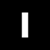
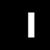
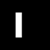
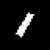
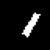
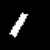
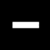
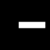
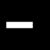
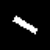
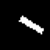
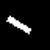
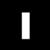
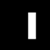
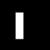
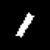
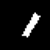
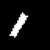
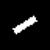
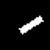
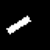
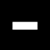
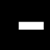
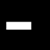
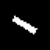
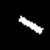
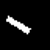
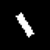
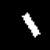
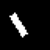

In [11]:
max_to_show = min(100, KERNELS.shape[0])

if max_to_show > 0:
    kernel_images = np.copy(KERNELS[:max_to_show])
    kernel_image_denoms = KERNEL_PARAMS[:max_to_show,1]
else:
    kernel_images = np.copy(KERNELS)
    kernel_image_denoms = KERNEL_PARAMS[:,1]

assert kernel_image_denoms.shape == (max_to_show,)
# Turn to column vector
kernel_image_denoms = kernel_image_denoms.reshape(1,-1).T
assert kernel_image_denoms.shape == (max_to_show, 1)
kernel_images *= 255 # turn to 0..255

_images = []
_captions = []

for i in range(kernel_images.shape[0]):
    _image = Image.frombytes('L', size=get_kernel_shape(kernel_images[i]), data=kernel_images[i].astype(np.uint8))
    _image = _image.resize((50, 50))
    _images.append(_image)
    _captions.append(str(i))
    
display_images_grid(_images, 16, captions=_captions)

In [151]:
%%time
NEXUSES = KERNELS
MIN_CLUSTER_SIZE = 5
CLUSTER_MASKS = []

for image in IMAGES_BW:
    active_nexuses = image * NEXUSES
    active_nexuses_counts = active_nexuses.sum(axis=1)
    assert active_nexuses_counts.shape == (NEXUSES.shape[0],)
    active_nexuses = active_nexuses[active_nexuses_counts >= MIN_CLUSTER_SIZE]
    CLUSTER_MASKS.extend(active_nexuses)

# TODO: more focused clusters (e.g. via random)
CLUSTER_MASKS = np.unique(CLUSTER_MASKS, axis=0)
cluster_means = 1 / np.pow(np.sum(CLUSTER_MASKS, axis=1), 1)
cluster_sigmas = cluster_means / 3
CLUSTERS = np.random.normal(cluster_means, cluster_sigmas, size=(CLUSTER_MASKS.shape[1], CLUSTER_MASKS.shape[0])).T

print(f'{len(CLUSTERS)} clusters generated')
        
# if CLUSTERS is None:
#     CLUSTERS = new_clusters
#     CLUSTER_MASKS = np.array(new_cluster_masks)
# else:
#     CLUSTERS = np.concatenate([CLUSTERS, new_clusters])
#     CLUSTER_MASKS = np.concatenate([CLUSTER_MASKS, new_cluster_masks])

241676 clusters generated
CPU times: user 32.2 s, sys: 522 ms, total: 32.7 s
Wall time: 32.5 s


In [149]:
nu = 0.05 # for oja it's better to set 0.01
batch_size = 100
epochs = 10

image_indices = np.arange(IMAGES_BW.shape[0])
method = 'rdzb' # oja, classic, rdzb

for batches in tqdm(range(epochs)):
    np.random.shuffle(image_indices)

    for ii in image_indices[:batch_size]:
        image = IMAGES_BW[ii]
        xes = image * CLUSTER_MASKS
        yeks = image @ CLUSTERS.T

        if method == 'oja':
            grow = (nu * yeks).reshape(1, -1).T
            grow = xes * grow 
            assert np.array_equal(xes[0] * (nu * yeks[0]), grow[0])
            stabil = (nu * np.pow(yeks, 2)).reshape(1, -1).T
            stabil = CLUSTERS * stabil 
            CLUSTERS = CLUSTERS + grow - stabil
        elif method == 'classic':
            denom = np.pow(CLUSTERS + xes * (nu * yeks).reshape(1, -1).T, 2)
            denom = np.sqrt(np.sum(denom, axis=1).reshape(1, -1).T)
            assert np.array_equal(denom[0], [np.sqrt(np.pow(CLUSTERS[0] + xes[0] * (nu * yeks[0]), 2).sum())])
            nomin = CLUSTERS + xes * (nu * yeks).reshape(1, -1).T
            CLUSTERS = nomin / denom
        elif method == 'rdzb':
            nomin = CLUSTERS + xes * (nu * yeks).reshape(1, -1).T
            denom = nomin.max(axis=1)
            assert np.array_equal(denom[0], nomin[0].max())
            CLUSTERS = (nomin.T / denom).T
        else:
            assert False, method

    # Pruning
    CLUSTER_MASKS = (CLUSTERS.T >= np.max(CLUSTERS, axis=1) * 0.75).T
    CLUSTERS = CLUSTERS * CLUSTER_MASKS

    degenerate_cluster_indices = np.argwhere(CLUSTER_MASKS.sum(axis=1) < MIN_CLUSTER_SIZE)
    CLUSTER_MASKS = np.delete(CLUSTER_MASKS, degenerate_cluster_indices, axis=0)
    CLUSTERS = np.delete(CLUSTERS, degenerate_cluster_indices, axis=0)
    print(f'{len(CLUSTERS)} clusters, {len(degenerate_cluster_indices)} dropped as degenerate')
    
    nu *= 0.9

  0%|          | 0/10 [00:00<?, ?it/s]

255840 clusters, 17230 dropped as degenerate
215327 clusters, 40513 dropped as degenerate
186432 clusters, 28895 dropped as degenerate
166329 clusters, 20103 dropped as degenerate
148966 clusters, 17363 dropped as degenerate
123827 clusters, 25139 dropped as degenerate
97768 clusters, 26059 dropped as degenerate
87519 clusters, 10249 dropped as degenerate
83306 clusters, 4213 dropped as degenerate
79211 clusters, 4095 dropped as degenerate



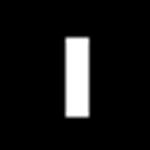
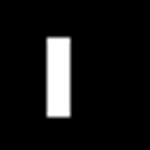
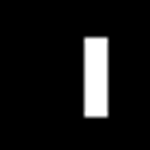
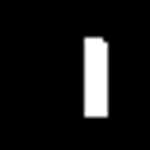
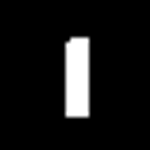
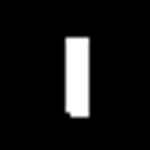
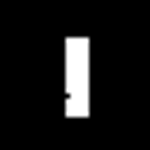
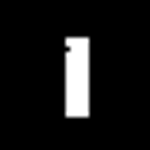
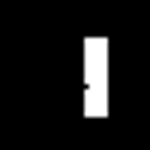
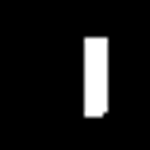
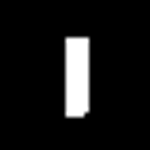
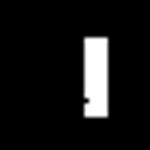
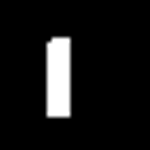
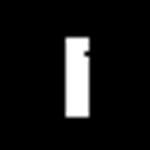
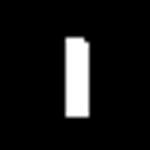
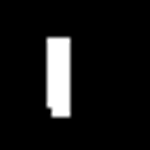
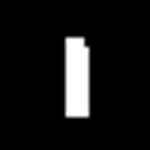
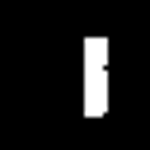
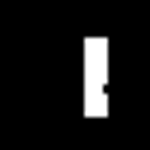
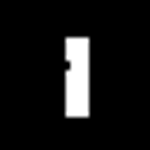
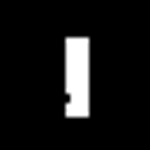
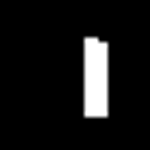
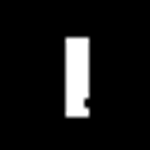
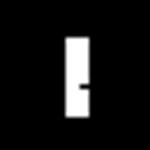
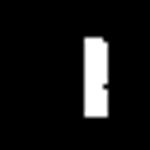
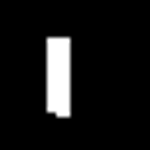
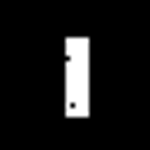
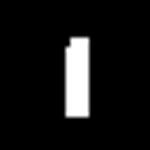
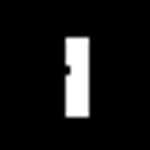
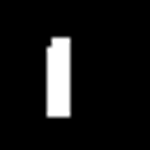
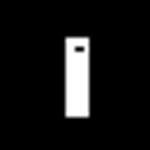
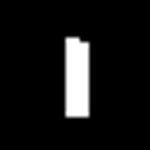
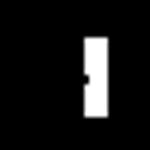
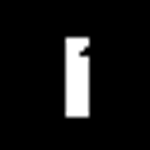
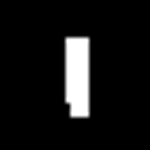
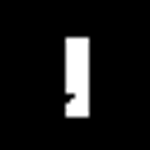
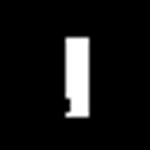
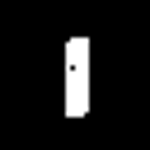
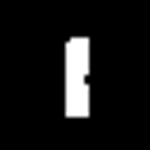
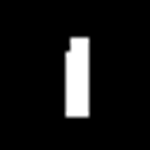
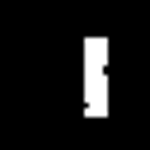
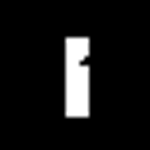
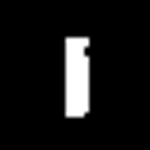
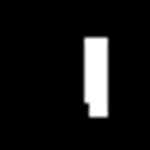
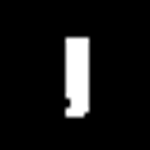
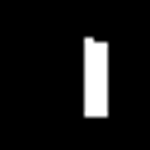
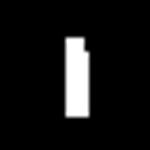
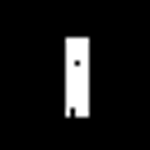
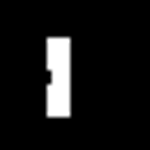
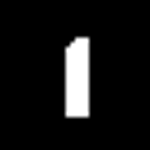
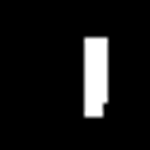
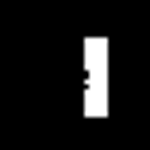
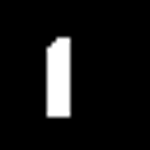
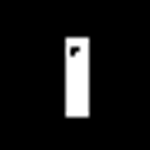
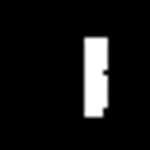
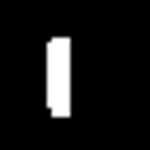
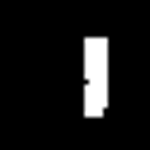
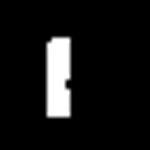
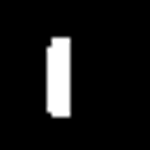
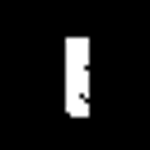
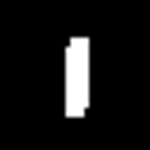
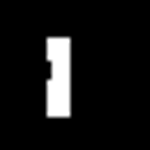
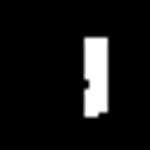
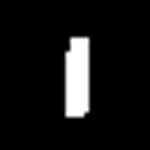
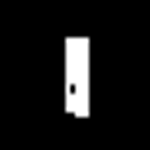
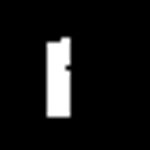
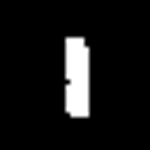
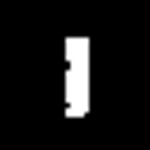
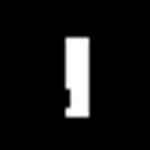
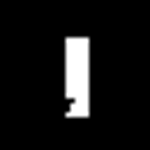
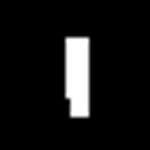
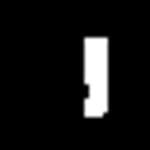
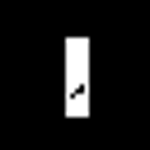
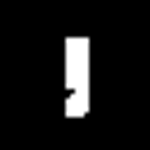
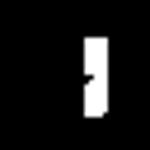
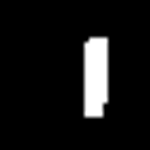
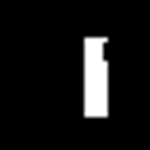
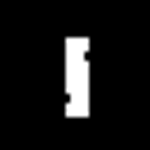
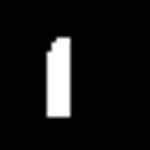
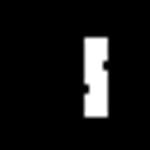
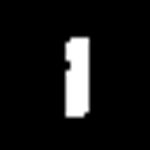
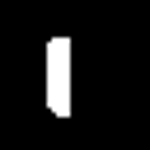
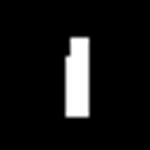
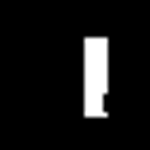
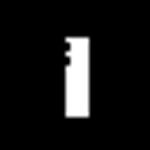
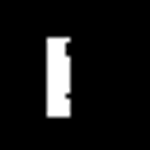
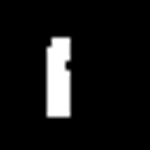
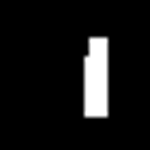
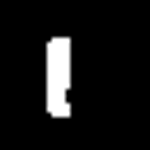
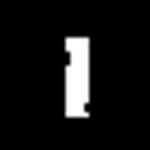
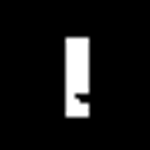
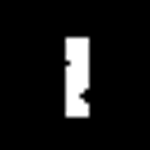
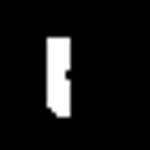
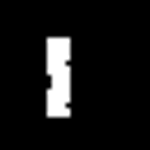
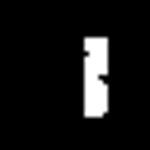
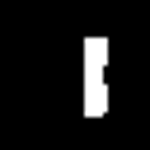
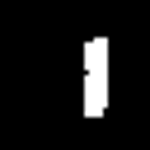
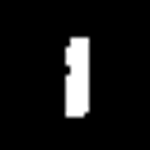
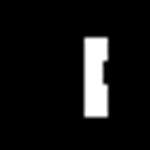
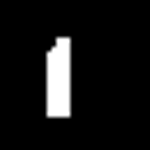

In [155]:
sorted_indices = np.argsort(-CLUSTER_MASKS.sum(axis=1))
max_to_show = min(100, len(sorted_indices))

_images = []
_captions = []

for i in sorted_indices[:max_to_show]:
    c = CLUSTER_MASKS[i]
    _image = Image.frombytes('L', size=get_kernel_shape(c), data=c.astype(np.uint8) * 255)
    _image = _image.resize((150, 150))
    _images.append(_image)
    _captions.append(f'#{i}, w: {(c == 1).sum()}')
    
display_images_grid(_images, 8, captions=_captions)

In [387]:
# # turn to adjustable weights
# assert np.array_equal((KERNELS[0] == 0).sum(), (KERNELS == 0).sum(axis=1)[0])
# means = 1 / np.pow((KERNELS == 0).sum(axis=1), 1)
# sigmas = means / 3
# CLUSTERS = np.random.normal(means, sigmas, size=(KERNELS.shape[1], KERNELS.shape[0]))
# CLUSTERS = KERNELS * CLUSTERS.T

In [390]:
# nu = 0.01
# batch_size = 1000
# epochs = 10
# image_indices = np.arange(IMAGES_BW.shape[0])
# method = 'plain' # oja, plain

# for batches in tqdm(range(epochs)):
#     np.random.shuffle(image_indices)
    
#     for ii in image_indices[:batch_size]:
#         image_bw = IMAGES_BW[ii]
#         xes = image_bw * KERNELS # use KERNELS as mask for input data
#         yeks = image_bw @ CLUSTERS.T

#         if method == 'oja':
#             grow = (nu * yeks).reshape(1, -1).T
#             grow = xes * grow 
#             assert np.array_equal(xes[0], image_bw * KERNELS[0])
#             assert np.array_equal(image_bw * KERNELS[0] * (nu * yeks)[0], grow[0])
#             stabil = (nu * np.pow(yeks, 2)).reshape(1, -1).T
#             stabil = KERNELS * CLUSTERS * stabil # use KERNELS as mask for clusters
    
#             CLUSTERS = CLUSTERS + grow - stabil
#         elif method == 'plain':
#             denom1 = np.pow(CLUSTERS + xes * (nu * yeks).reshape(1, -1).T, 2)
#             denom = np.sqrt(np.sum(denom1, axis=1).reshape(1, -1).T)
#             assert np.array_equal(denom[0], [np.sqrt(np.pow(CLUSTERS[0] + (nu * yeks[0] * KERNELS[0] * image_bw), 2).sum())])
#             nomin = CLUSTERS + xes * (nu * yeks).reshape(1, -1).T
#             CLUSTERS = nomin / denom
#         else:
#             assert False, method

#         # print(ii, np.unique(CLUSTERS[0]))
#         # break

#     nu *= 0.9

  0%|          | 0/10 [00:00<?, ?it/s]

In [202]:
sz = int(np.sqrt(IMAGES.shape[1]))
center_ij = int(sz * (sz / 2 + 0.5))
assert np.isclose(IMAGES.std(axis=0)[center_ij], IMAGES[:,center_ij].std())
center_ij, IMAGES[:,center_ij].mean(), IMAGES[:,center_ij].std()

(528, np.float64(149.90707531790022), np.float64(125.51562841215411))

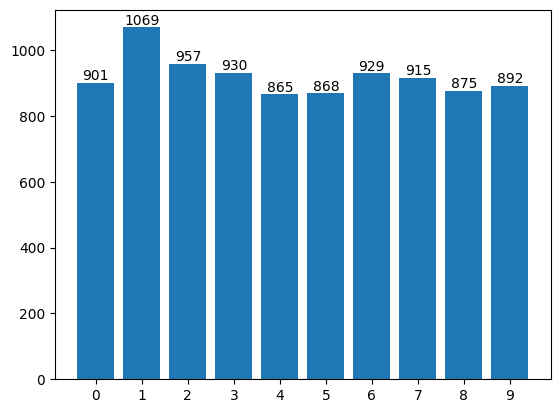

In [373]:
# mask = (IMAGES_METADATA.value != '3') & (IMAGES_METADATA.value != '9')
#mask = (IMAGES_METADATA.value == '1') | (IMAGES_METADATA.value == '5')
# mask = (IMAGES_METADATA.value == '5')
mask = np.full(IMAGES.shape[0], True)
SUBIMAGES = IMAGES[mask]
SUBIMAGES_MEAN = SUBIMAGES.mean(axis=0)
SUBIMAGES_STD = SUBIMAGES.std(axis=0)
SUBIMAGES_PREPD = preprocessing.scale(SUBIMAGES)

values = np.unique_counts(IMAGES_METADATA.value[mask])
p = plt.bar(values.values, values.counts)
plt.bar_label(p, values.counts)
plt.show()

In [374]:
%%time
pca = PCA()
pca.fit(SUBIMAGES_PREPD)
pca_data = pca.transform(SUBIMAGES_PREPD)

CPU times: user 19.2 s, sys: 176 ms, total: 19.4 s
Wall time: 1.89 s


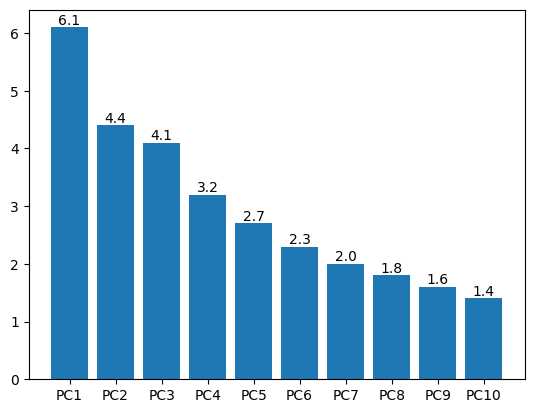

In [375]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)[:10]
per_var_names = [f'PC{i+1}' for i in range(len(per_var))]

p = plt.bar(per_var_names, per_var)
plt.bar_label(p, map(str, per_var))
plt.show()

In [376]:
per_var.sum()

np.float64(29.6)


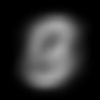
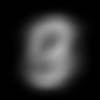
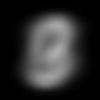
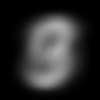
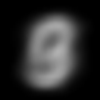
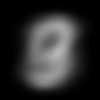
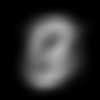
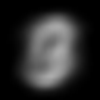
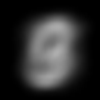
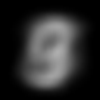
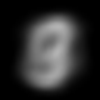
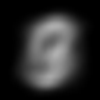
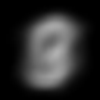
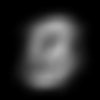
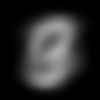
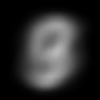
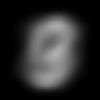
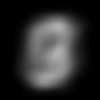
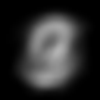
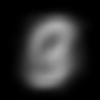
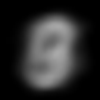
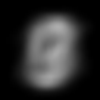
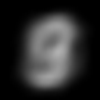
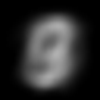
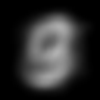
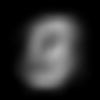
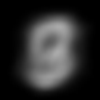
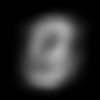
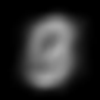
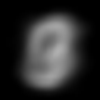
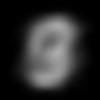
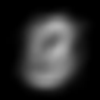
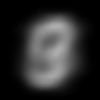
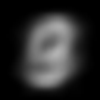
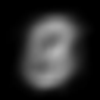
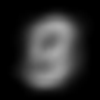
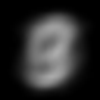
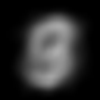
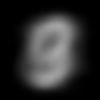
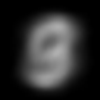
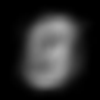
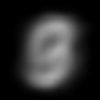
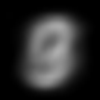
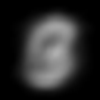
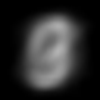
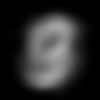
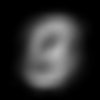
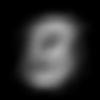
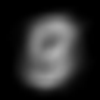
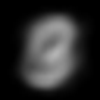
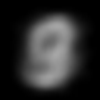
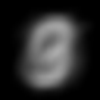
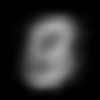
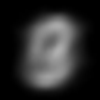
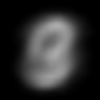
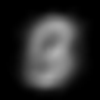
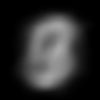
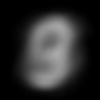
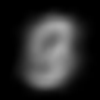
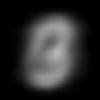
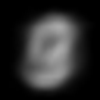
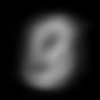
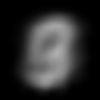
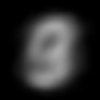
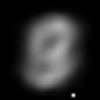
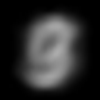
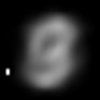
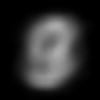
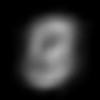
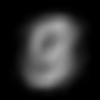
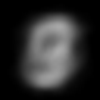
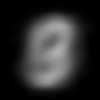
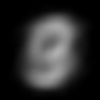
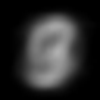
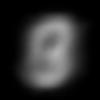
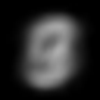
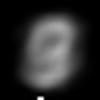
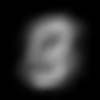
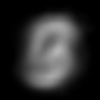
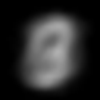
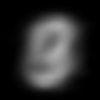
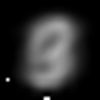
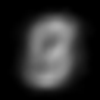
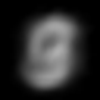
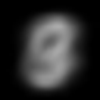
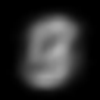
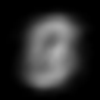
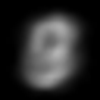
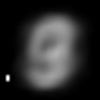
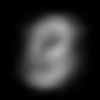
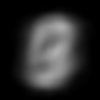
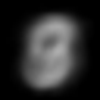
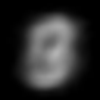
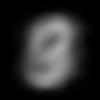
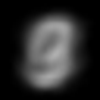
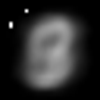
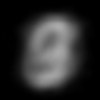
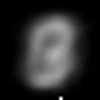
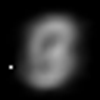
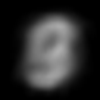

In [386]:
pc_imgs = []
pc_captions = {}

for i in range(min(100, len(pca.components_))):
    pc = pca.components_[i].copy()
    pc *= SUBIMAGES_STD
    pc += SUBIMAGES_MEAN
    # pc[pc < 128] = 0
    # pc[pc > 0] = 255
    #display_kernel_raw(pc, 1)
    pc_img = Image.frombytes('L', size=(sz, sz), data=pc.astype(np.uint8)).resize((100, 100))
    pc_imgs.append(pc_img)
    pc_captions[id(pc_img)] = f'{pca.explained_variance_ratio_[i] * 100:.1f}%'

display_images(pc_imgs, captions=pc_captions)    


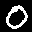
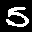
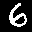
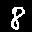
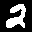
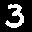
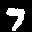
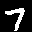
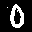
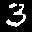
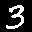
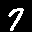
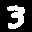
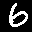
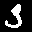
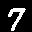
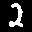
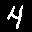
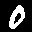
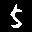
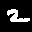
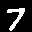
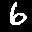
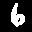
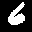
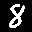
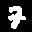
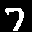
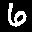
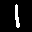
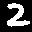
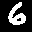
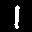
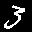
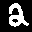
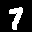
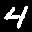
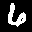
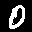
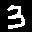
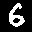
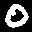
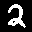
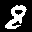
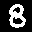
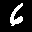
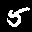
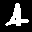
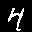
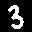
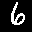
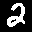
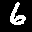
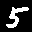
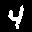
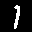
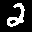
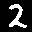
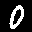
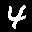
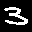
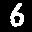
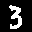
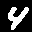
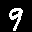
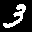
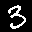
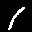
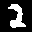
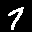
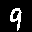
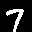
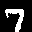
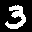
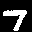
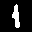
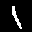
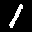
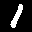
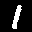
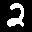
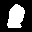
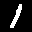
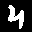
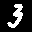
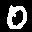
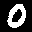
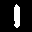
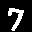
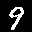
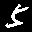
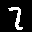
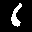
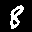
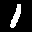
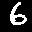
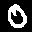
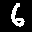
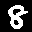
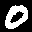

In [378]:
display_images(map(lambda x: Image.frombytes('L', size=(sz, sz), data=x), SUBIMAGES[:100]))

In [379]:
pca_components_mod = pca.components_.copy()

for i in range(len(pca_components_mod)):
    pc = pca_components_mod[i]
    pc *= SUBIMAGES_STD
    pc += SUBIMAGES_MEAN
    pc[pc < 128] = 0
    pc[pc > 0] = 255


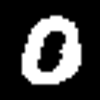
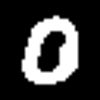
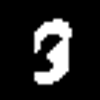
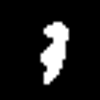
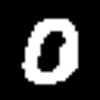
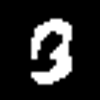
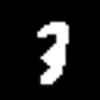
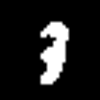
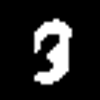
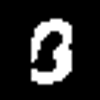
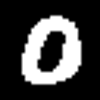
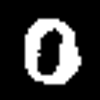
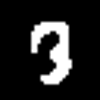
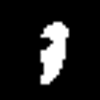
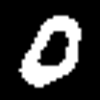
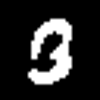
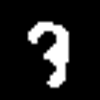
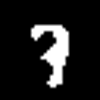
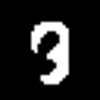
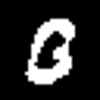
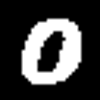
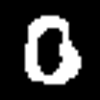
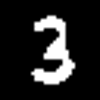
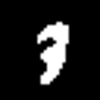
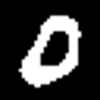
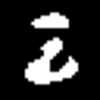
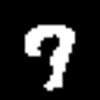
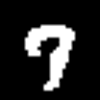
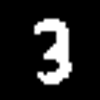
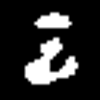
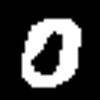
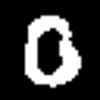
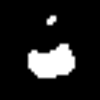
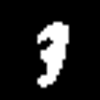
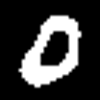
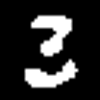
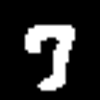
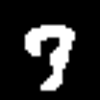
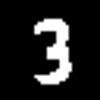
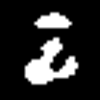
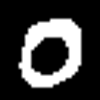
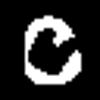
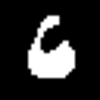
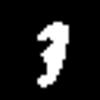
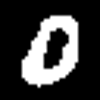
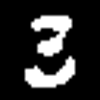
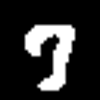
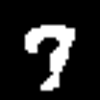
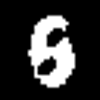
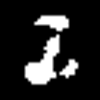
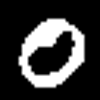
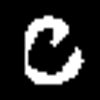
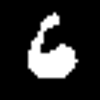
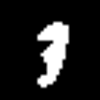
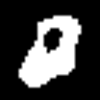
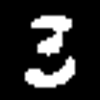
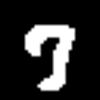
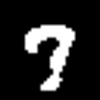
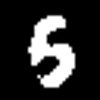
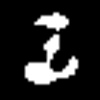
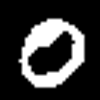
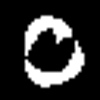
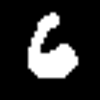
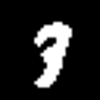
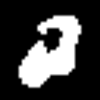
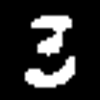
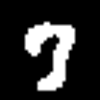
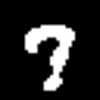
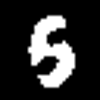
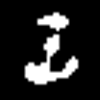
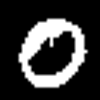
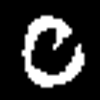
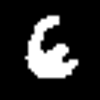
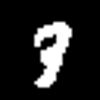
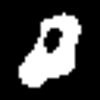
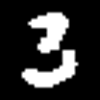
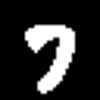
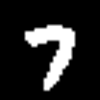
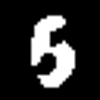
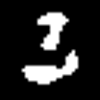
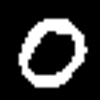
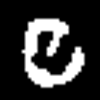
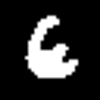
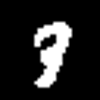
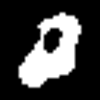
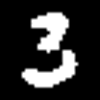
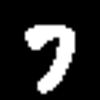
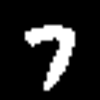
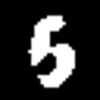
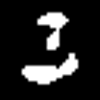
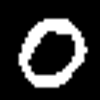
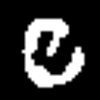
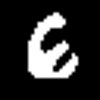
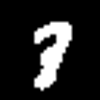
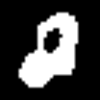
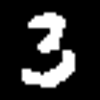
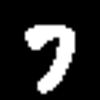
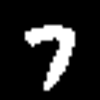
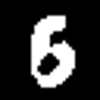
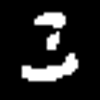

In [385]:
imgs_restored = []
imgs_restored_caps = []

for pc_count in range(10):
    for i in range(min(10, len(pca_data))):
        img_compressed = pca_data[i].copy()
        img_compressed[pc_count+1:] = 0
        img_restored = img_compressed @ pca.components_
        #img_restored = img_compressed @ pca_components_mod
        img_restored *= SUBIMAGES_STD
        img_restored += SUBIMAGES_MEAN
        img_restored[img_restored < 128] = 0
        img_restored[img_restored > 0] = 255
        imgs_restored.append(Image.frombytes('L', size=(sz, sz), data=img_restored.astype(np.uint8)).resize((100, 100)))
        imgs_restored_caps.append(f'PC {pc_count+1}, #{i}')

display_images_grid(imgs_restored, col_count=min(10, len(pca_data)), captions=imgs_restored_caps)    

In [389]:
XY_DATA = []

for y in range(IMAGE_SIZE):
    for x in range(IMAGE_SIZE):
        i = y * IMAGE_SIZE + x
        samples_indices = np.argwhere(SUBIMAGES[:,i] > 0)
        samples_indices = samples_indices.reshape(-1)

        for si in samples_indices:
            XY_DATA.append([x, y])

XY_DATA = np.array(XY_DATA)

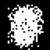

In [399]:
test_image = Image.new('L', size=(IMAGE_SIZE, IMAGE_SIZE))
test_image_draw = ImageDraw.Draw(test_image)

for xy in XY_DATA[np.random.randint(len(XY_DATA), size=1000)]:
    test_image_draw.point(list(xy), fill=255)
    
test_image.resize((50, 50))

In [400]:
%time
xy_pca = PCA()
xy_pca.fit(XY_DATA)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 3.34 μs


PCA()

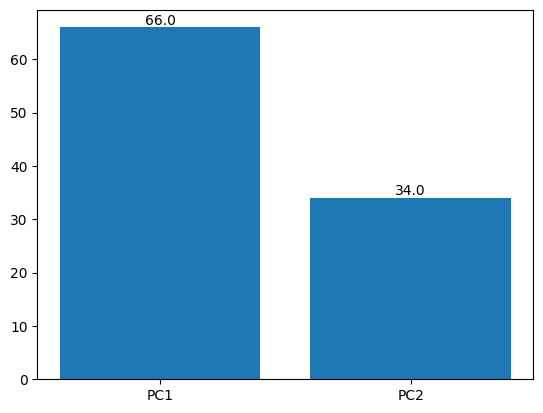

In [401]:
per_var = np.round(xy_pca.explained_variance_ratio_ * 100, decimals=1)[:10]
per_var_names = [f'PC{i+1}' for i in range(len(per_var))]

p = plt.bar(per_var_names, per_var)
plt.bar_label(p, map(str, per_var))
plt.show()